In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn import model_selection
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import accuracy_score
from scipy.stats import skew, kurtosis
from sklearn.svm import SVR
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Load the data
df = pd.read_csv("/content/merged_output (1).csv")
df = pd.DataFrame(df)

# Define the window ranges as pairs of (start, end)
window_ranges = [(0,1000),(0, 196),(197, 314),(315, 442),(443, 597),(598, 782),(783, 1000)]

# Function to extract features from a window
def extract_features(window):
    features = {
        'mean': np.mean(window),
        'std_dev': np.std(window),
        'min': np.min(window),
        'max': np.max(window),
        'variance': np.var(window),
        'skewness': skew(window),
        'kurtosis': kurtosis(window),
        'coefficient_of_variance': np.std(window) / np.mean(window)
    }
    return features

# List to hold all the feature data for all rows
all_features = []

# Iterate over each row in the DataFrame
for i, row in df.iterrows():
    row_features = {}

    for j, (start, end) in enumerate(window_ranges):
        window = row[2:].values[start:end+1]  # Extract the window from the row
        window_features = extract_features(window)

        for feature_name, value in window_features.items():
            row_features[f'{feature_name}_{j+1}'] = value
    all_features.append(row_features)



features_df = pd.DataFrame(all_features)

final_df = pd.concat([df[['Tag ID', 'Deformation']], features_df], axis=1)

# Save the final DataFrame to a CSV file
final_df.to_csv('extracted_features.csv', index=False)


In [ ]:
final_df = final_df.sample(frac=1, random_state=0)
#features = final_df.iloc[:, 2:3]
features = final_df.iloc[:, 2:]
target = final_df['Tag ID']

# Split data
X_dev, X_test, y_dev, y_test = train_test_split(features, target, test_size=0.2, random_state=0)
# Further split the remaining 80%: 75% training and 25% validation
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25, random_state=0)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_dev = scaler.transform(X_dev)


Random Forest with overfitting

In [ ]:
rf_reg =  RandomForestRegressor(random_state=0)
rf_reg.fit(X_train, y_train)

print("RMSE Score for Gradient Boosting Without Hyperparamter tuning")

# Predict and evaluate
y_pred_rf = rf_reg.predict(X_train)
mse_train_rf = mean_squared_error(y_train, y_pred_rf)
rmse_train_rf = np.sqrt(mse_train_rf)
print('training accuracy',rmse_train_rf)

y_pred_val_rf = rf_reg.predict(X_val)
mse_val_rf = mean_squared_error(y_val, y_pred_val_rf)
rmse_val_rf = np.sqrt(mse_val_rf)
print('validation accuracy',rmse_val_rf)

y_pred_test_rf = rf_reg.predict(X_test)
mse_test_rf = mean_squared_error(y_val, y_pred_test_rf)
rmse_test_rf = np.sqrt(mse_test_rf)
print('Testing accuracy',rmse_test_rf)

RMSE Score for Gradient Boosting Without Hyperparamter tuning
training accuracy 1.2211486180512265
validation accuracy 2.8363695647239457
Testing accuracy 24.42229624433693


RANDOM FOREST REGRESSOR Feature Extraction

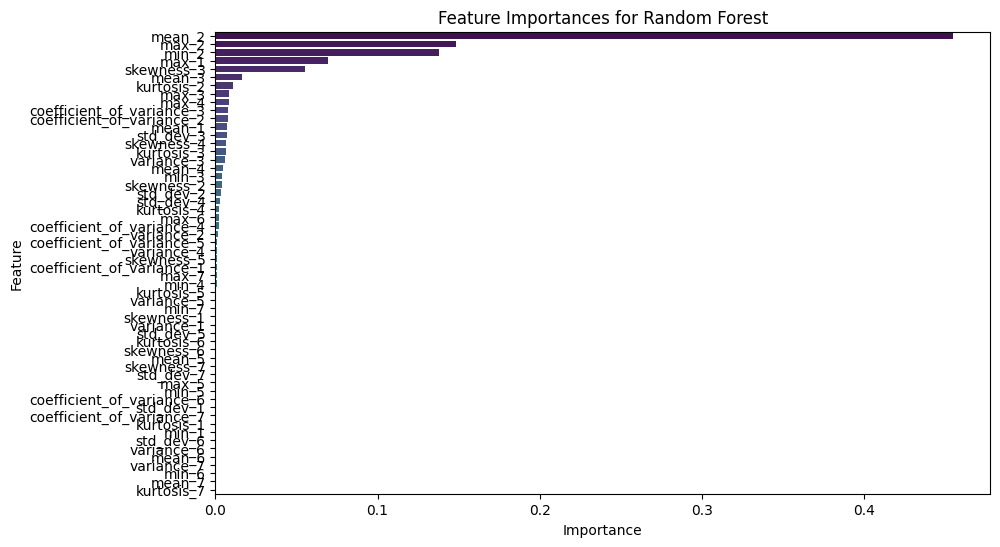

In [ ]:
#fitting the Random forest model

rf_reg = RandomForestRegressor(random_state=0)
rf_reg.fit(X_train, y_train)
#feature importance

importances = rf_reg.feature_importances_
# Create a DataFrame to display the importances
feature_importances = pd.DataFrame({'Feature': features.columns, 'Importance': importances})
# Sorting the features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plotting the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette="viridis")
plt.title('Feature Importances for Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()



In [ ]:
# Step 1: Select important features (e.g., importance > 0.001)
threshold = 0.001  # Define a threshold for feature importance
important_features = feature_importances[feature_importances['Importance'] > threshold]['Feature'].tolist()

print("Features with importance greater than 0.001:")
for feature in important_features:
    print(feature)

index=[features.columns.get_loc(f) for f in important_features]
X_train_reduced = X_train[:, index]
X_val_reduced = X_val[:, index]
X_test_reduced = X_test[:, index]
X_dev_reduced = X_dev[:, index]

Features with importance greater than 0.001:
mean_2
max_2
min_2
max_1
skewness_3
mean_3
kurtosis_2
max_3
max_4
coefficient_of_variance_3
coefficient_of_variance_2
mean_1
std_dev_3
skewness_4
kurtosis_3
variance_3
mean_4
min_3
skewness_2
std_dev_2
std_dev_4
kurtosis_4
max_6
coefficient_of_variance_4
variance_2


RMSE Score for Random Forest With Reduced Features
Training RMSE: 1.0900989815029112
Validation RMSE: 2.821473292175834
Test RMSE: 2.0937893509505314


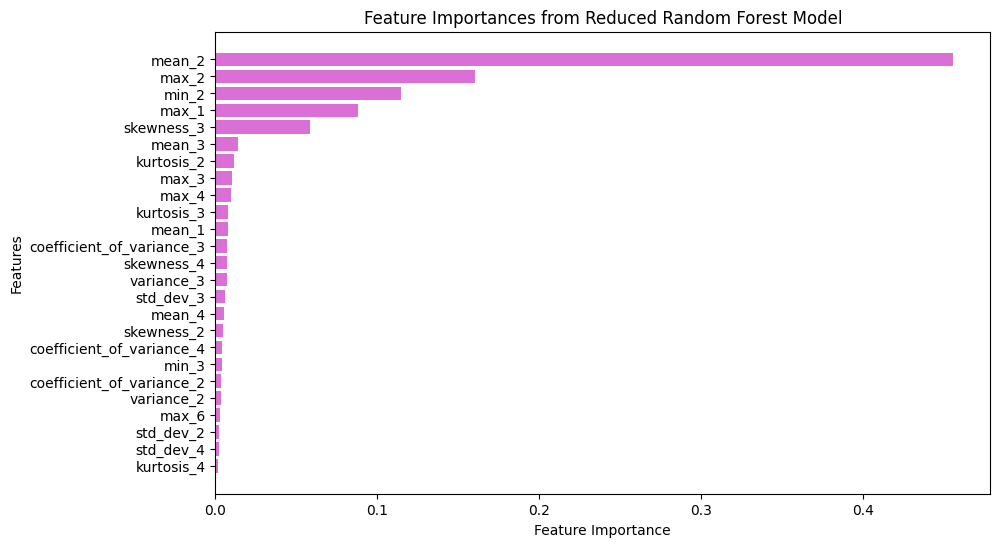

In [ ]:
rf_reg_reduced = RandomForestRegressor(random_state=0)
rf_reg_reduced.fit(X_train_reduced, y_train)

# Evaluate the new model
print("RMSE Score for Random Forest With Reduced Features")

# Training set evaluation
y_pred_train_rf_reduced = rf_reg_reduced.predict(X_train_reduced)
mse_train_rf_reduced = mean_squared_error(y_train, y_pred_train_rf_reduced)
rmse_train_rf_reduced = np.sqrt(mse_train_rf_reduced)
print('Training RMSE:', rmse_train_rf_reduced)

# Validation set evaluation
y_pred_val_rf_reduced = rf_reg_reduced.predict(X_val_reduced)
mse_val_rf_reduced = mean_squared_error(y_val, y_pred_val_rf_reduced)
rmse_val_rf_reduced = np.sqrt(mse_val_rf_reduced)
print('Validation RMSE:', rmse_val_rf_reduced)

# Test set evaluation
y_pred_test_rf_reduced = rf_reg_reduced.predict(X_test_reduced)
mse_test_rf_reduced = mean_squared_error(y_test, y_pred_test_rf_reduced)
rmse_test_rf_reduced = np.sqrt(mse_test_rf_reduced)
print('Test RMSE:', rmse_test_rf_reduced)

# Plotting feature importances from the reduced model
sorted_importances = pd.DataFrame({
    'Feature': important_features,
    'Importance': rf_reg_reduced.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(sorted_importances['Feature'], sorted_importances['Importance'], color='orchid')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importances from Reduced Random Forest Model')
plt.gca().invert_yaxis()
plt.show()



Feature Extraction with Hyperparameter Tuning Random Forest Regression

In [ ]:
#threshold=0.001
param_grid_rf = {
    'n_estimators': [800, 1000],  # Reduce the number of trees slightly to avoid excessive complexity and overfitting
    'max_depth': [7, 9, 10],  # Limit tree depth to focus on simpler models that generalize better
    'max_features': [0.3, 0.4],  # Reduce the number of features considered at each split for less overfitting
    'min_samples_split': [3, 4, 5],  # Allow earlier splitting to prevent overly specific tree branches
    'min_samples_leaf': [3, 4, 5],  # Increase minimum samples per leaf to improve regularization and prevent capturing noise
    'max_leaf_nodes': [40, 50, 60],  # Limit the number of leaf nodes to control complexity
    'bootstrap': [True],  # Stick with bootstrap sampling for robust ensemble learning
}



# Initialize the RandomForest model
rf_reg = RandomForestRegressor(random_state=0)

# Apply GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf_reg, param_grid=param_grid_rf,
                               cv=10, n_jobs=-1)

# Fit the model
grid_search_rf.fit(X_train_reduced, y_train)

# Get the best model
best_rf = grid_search_rf.best_estimator_

# Evaluate the model
print("RMSE Score for Random Forest With Hyperparameter Tuning")

# Training set evaluation
y_pred_train_rf = best_rf.predict(X_train_reduced)
mse_train_rf = mean_squared_error(y_train, y_pred_train_rf)
rmse_train_rf = np.sqrt(mse_train_rf)
print('Training RMSE:', rmse_train_rf)

# Validation set evaluation
y_pred_val_rf = best_rf.predict(X_val_reduced)
mse_val_rf = mean_squared_error(y_val, y_pred_val_rf)
rmse_val_rf = np.sqrt(mse_val_rf)
print('Validation RMSE:', rmse_val_rf)

# Test set evaluation
y_pred_test_rf = best_rf.predict(X_test_reduced)
mse_test_rf = mean_squared_error(y_test, y_pred_test_rf)
rmse_test_rf = np.sqrt(mse_test_rf)
print('Test RMSE:', rmse_test_rf)

# Best hyperparameters found
print("Best Hyperparameters for Random Forest:", grid_search_rf.best_params_)


RMSE Score for Random Forest With Hyperparameter Tuning
Training RMSE: 1.5406991181003031
Validation RMSE: 2.4395431821032205
Test RMSE: 2.5158398547096126
Best Hyperparameters for Random Forest: {'bootstrap': True, 'max_depth': 7, 'max_features': 0.4, 'max_leaf_nodes': 40, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 800}


In [ ]:
#threshold=0.001
param_grid_rf = {
    'n_estimators': [1000,1100,1200],  # Reduce the number of trees slightly to avoid excessive complexity and overfitting
    'max_depth': [7, 9, 10],  # Limit tree depth to focus on simpler models that generalize better
    'max_features': ['sqrt','log2',0.2],  # Reduce the number of features considered at each split for less overfitting
    'min_samples_split': [2, 3, 4, 5],  # Allow earlier splitting to prevent overly specific tree branches
    'min_samples_leaf': [2, 3, 4, 5],  # Increase minimum samples per leaf to improve regularization and prevent capturing noise
    'max_leaf_nodes': [30, 40, 50, 60],  # Limit the number of leaf nodes to control complexity
    'bootstrap': [True],  # Stick with bootstrap sampling for robust ensemble learning
}



# Initialize the RandomForest model
rf_reg = RandomForestRegressor(random_state=0)

# Apply GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf_reg, param_grid=param_grid_rf,
                               cv=10, n_jobs=-1)

# Fit the model
grid_search_rf.fit(X_train_reduced, y_train)

# Get the best model
best_rf = grid_search_rf.best_estimator_

# Evaluate the model
print("RMSE Score for Random Forest With Hyperparameter Tuning")

# Training set evaluation
y_pred_train_rf = best_rf.predict(X_train_reduced)
mse_train_rf = mean_squared_error(y_train, y_pred_train_rf)
rmse_train_rf = np.sqrt(mse_train_rf)
print('Training RMSE:', rmse_train_rf)

# Validation set evaluation
y_pred_val_rf = best_rf.predict(X_val_reduced)
mse_val_rf = mean_squared_error(y_val, y_pred_val_rf)
rmse_val_rf = np.sqrt(mse_val_rf)
print('Validation RMSE:', rmse_val_rf)

# Test set evaluation
y_pred_test_rf = best_rf.predict(X_test_reduced)
mse_test_rf = mean_squared_error(y_test, y_pred_test_rf)
rmse_test_rf = np.sqrt(mse_test_rf)
print('Test RMSE:', rmse_test_rf)

# Best hyperparameters found
print("Best Hyperparameters for Random Forest:", grid_search_rf.best_params_)


In [ ]:
param_grid_rf = {
    'n_estimators': [800, 900, 1000],  # Increase the range of trees
    'max_depth': [6, 7, 9],  # Test with deeper trees
    'max_features': ['sqrt','log2','auto',0.2, 0.3, 0.4],  # Explore different fractions of features considered at each split
    'min_samples_split': [2, 3, 4],  # Try smaller splits
    'min_samples_leaf': [1, 2, 3],  # Experiment with fewer samples per leaf
    'max_leaf_nodes': [30,40, 50, 70],  # Allow more leaf nodes
    'bootstrap': [True, False],  # Also test without bootstrap
}


# Initialize the RandomForest model
rf_reg = RandomForestRegressor(random_state=0)

# Apply GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf_reg, param_grid=param_grid_rf,
                               cv=10, n_jobs=-1)

# Fit the model
grid_search_rf.fit(X_train_reduced, y_train)

# Get the best model
best_rf = grid_search_rf.best_estimator_

# Evaluate the model
print("RMSE Score for Random Forest With Hyperparameter Tuning")

# Training set evaluation
y_pred_train_rf = best_rf.predict(X_train_reduced)
mse_train_rf = mean_squared_error(y_train, y_pred_train_rf)
rmse_train_rf = np.sqrt(mse_train_rf)
print('Training RMSE:', rmse_train_rf)

# Validation set evaluation
y_pred_val_rf = best_rf.predict(X_val_reduced)
mse_val_rf = mean_squared_error(y_val, y_pred_val_rf)
rmse_val_rf = np.sqrt(mse_val_rf)
print('Validation RMSE:', rmse_val_rf)

# Test set evaluation
y_pred_test_rf = best_rf.predict(X_test_reduced)
mse_test_rf = mean_squared_error(y_test, y_pred_test_rf)
rmse_test_rf = np.sqrt(mse_test_rf)
print('Test RMSE:', rmse_test_rf)

# Best hyperparameters found
print("Best Hyperparameters for Random Forest:", grid_search_rf.best_params_)


KeyboardInterrupt: 

Gradient Boosting with overfitting

In [ ]:
gbr_reg = GradientBoostingRegressor(random_state=0)
gbr_reg.fit(X_train, y_train)

print("RMSE Score for Gradient Boosting Without Hyperparamter tuning")

# Predict and evaluate
y_pred_gbr = gbr_reg.predict(X_train)
mse_train_gbr = mean_squared_error(y_train, y_pred_gbr)
rmse_train_gbr = np.sqrt(mse_train_gbr)
print('training accuracy',rmse_train_gbr)

y_pred_val_gbr = gbr_reg.predict(X_val)
mse_val_gbr = mean_squared_error(y_val, y_pred_val_gbr)
rmse_val_gbr = np.sqrt(mse_val_gbr)
print('validation accuracy',rmse_val_gbr)

y_pred_test_gbr = gbr_reg.predict(X_test)
mse_test_gbr = mean_squared_error(y_val, y_pred_test_gbr)
rmse_test_gbr = np.sqrt(mse_test_gbr)
print('Testing accuracy',rmse_test_gbr)




RMSE Score for Gradient Boosting Without Hyperparamter tuning
training accuracy 0.03542718873875543
validation accuracy 2.530232951906466
Testing accuracy 24.417856930534654


Gradient Boosting  with Feature Extraction

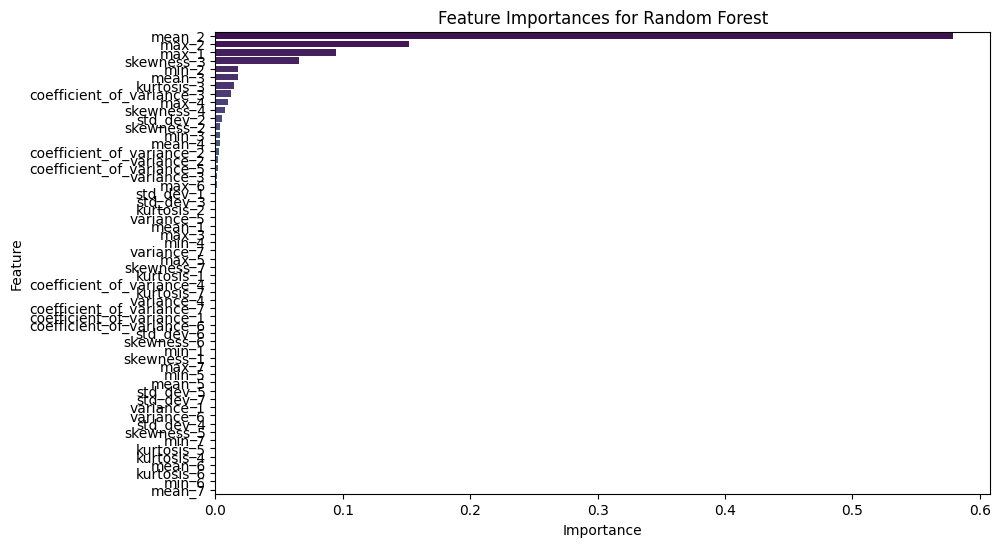

In [ ]:
#fitting the Random forest model

rf_reg = GradientBoostingRegressor(random_state=0)
rf_reg.fit(X_train, y_train)
#feature importance

importances = rf_reg.feature_importances_
# Create a DataFrame to display the importances
feature_importances = pd.DataFrame({'Feature': features.columns, 'Importance': importances})
# Sorting the features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plotting the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette="viridis")
plt.title('Feature Importances for Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
# Step 1: Select important features (e.g., importance > 0.005)
threshold = 0.001  # Define a threshold for feature importance
important_features = feature_importances[feature_importances['Importance'] > threshold]['Feature'].tolist()

print("Features with importance greater than 0.005:")
for feature in important_features:
    print(feature)

index=[features.columns.get_loc(f) for f in important_features]
X_train_reduced = X_train[:, index]
X_val_reduced = X_val[:, index]
X_test_reduced = X_test[:, index]
X_dev_reduced = X_dev[:, index]

Features with importance greater than 0.005:
mean_2
max_2
max_1
skewness_3
min_2
mean_3
kurtosis_3
coefficient_of_variance_3
max_4
skewness_4
std_dev_2
skewness_2
min_3
mean_4
coefficient_of_variance_2
variance_2
coefficient_of_variance_5
variance_3


RMSE Score for Gradient Boosting With Reduced Features
Training RMSE: 0.07110355189064219
Validation RMSE: 2.3508658036680217
Test RMSE: 1.903392881666704


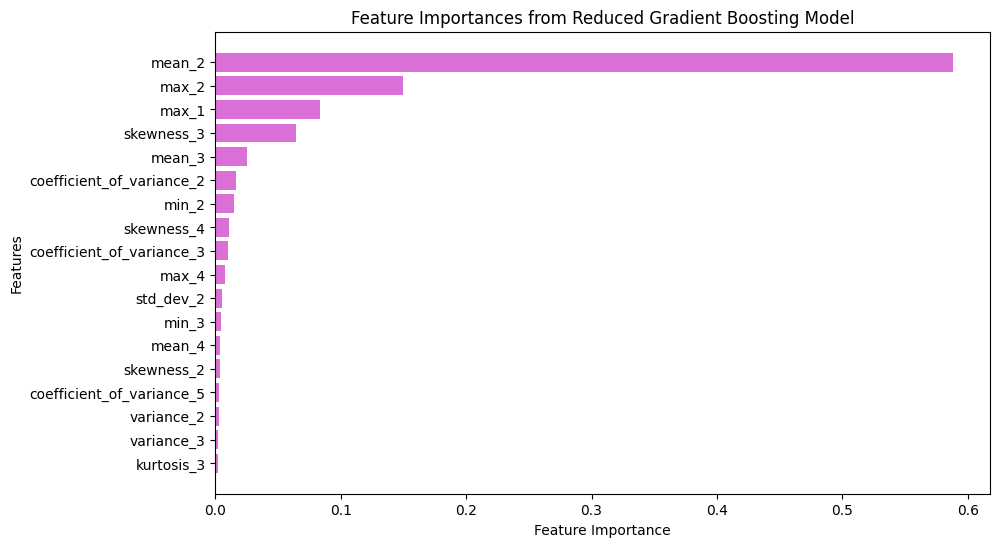

In [ ]:
# Fit the Gradient Boosting Regressor model with reduced features
gb_reg_reduced = GradientBoostingRegressor(random_state=0)
gb_reg_reduced.fit(X_train_reduced, y_train)

# Evaluate the new model
print("RMSE Score for Gradient Boosting With Reduced Features")

# Training set evaluation
y_pred_train_gb_reduced = gb_reg_reduced.predict(X_train_reduced)
mse_train_gb_reduced = mean_squared_error(y_train, y_pred_train_gb_reduced)
rmse_train_gb_reduced = np.sqrt(mse_train_gb_reduced)
print('Training RMSE:', rmse_train_gb_reduced)

# Validation set evaluation
y_pred_val_gb_reduced = gb_reg_reduced.predict(X_val_reduced)
mse_val_gb_reduced = mean_squared_error(y_val, y_pred_val_gb_reduced)
rmse_val_gb_reduced = np.sqrt(mse_val_gb_reduced)
print('Validation RMSE:', rmse_val_gb_reduced)

# Test set evaluation
y_pred_test_gb_reduced = gb_reg_reduced.predict(X_test_reduced)
mse_test_gb_reduced = mean_squared_error(y_test, y_pred_test_gb_reduced)
rmse_test_gb_reduced = np.sqrt(mse_test_gb_reduced)
print('Test RMSE:', rmse_test_gb_reduced)

# Plot feature importances from the reduced model
sorted_importances = pd.DataFrame({
    'Feature': important_features,
    'Importance': gb_reg_reduced.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(sorted_importances['Feature'], sorted_importances['Importance'], color='orchid')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importances from Reduced Gradient Boosting Model')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Define the parameter grid for Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 150, 200],  # Increase to give the model more boosting rounds while still capping it
    'learning_rate': [0.01, 0.03, 0.05],  # Focus on smaller learning rates for better generalization
    'max_depth': [3, 4, 5],  # Stick to shallower trees to reduce overfitting
    'min_samples_split': [3, 5, 7],  # Increase minimum splits to promote better generalization
    'min_samples_leaf': [2, 3, 4],  # Slightly larger minimum leaf sizes to reduce noise
    'alpha': [0.01, 0.05],  # Simplify with two options, focusing on moderate regularization
    'subsample': [0.7, 0.8, 0.9]  # Subsample further for more randomness and less overfitting
}


# Initialize the GradientBoosting model
gb_reg = GradientBoostingRegressor(random_state=0)

# Apply GridSearchCV
grid_search_gb = GridSearchCV(estimator=gb_reg, param_grid=param_grid_gb,
                               cv=10, n_jobs=-1)

# Fit the model
grid_search_gb.fit(X_train_reduced, y_train)

# Get the best model
best_gb = grid_search_gb.best_estimator_

# Evaluate the model
print("RMSE Score for Gradient Boosting With Hyperparameter Tuning")

# Training set evaluation
y_pred_train_gb = best_gb.predict(X_train_reduced)
mse_train_gb = mean_squared_error(y_train, y_pred_train_gb)
rmse_train_gb = np.sqrt(mse_train_gb)
print('Training RMSE:', rmse_train_gb)

# Validation set evaluation
y_pred_val_gb = best_gb.predict(X_val_reduced)
mse_val_gb = mean_squared_error(y_val, y_pred_val_gb)
rmse_val_gb = np.sqrt(mse_val_gb)
print('Validation RMSE:', rmse_val_gb)

# Test set evaluation
y_pred_test_gb = best_gb.predict(X_test_reduced)
mse_test_gb = mean_squared_error(y_test, y_pred_test_gb)
rmse_test_gb = np.sqrt(mse_test_gb)
print('Test RMSE:', rmse_test_gb)

# Best hyperparameters found
print("Best Hyperparameters for Gradient Boosting:", grid_search_gb.best_params_)

KeyboardInterrupt: 

-----------------------------------------------------------------
**The** **END**

Fitting 10 folds for each of 3600 candidates, totalling 36000 fits
RMSE Score for Gradient Boosting With Hyperparameter Tuning
Training RMSE: 0.002351034082661242
Validation RMSE: 1.8319007110682899
Test RMSE: 1.971203186371836
Best Hyperparameters for Gradient Boosting: {'alpha': 0.005, 'learning_rate': 0.05, 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


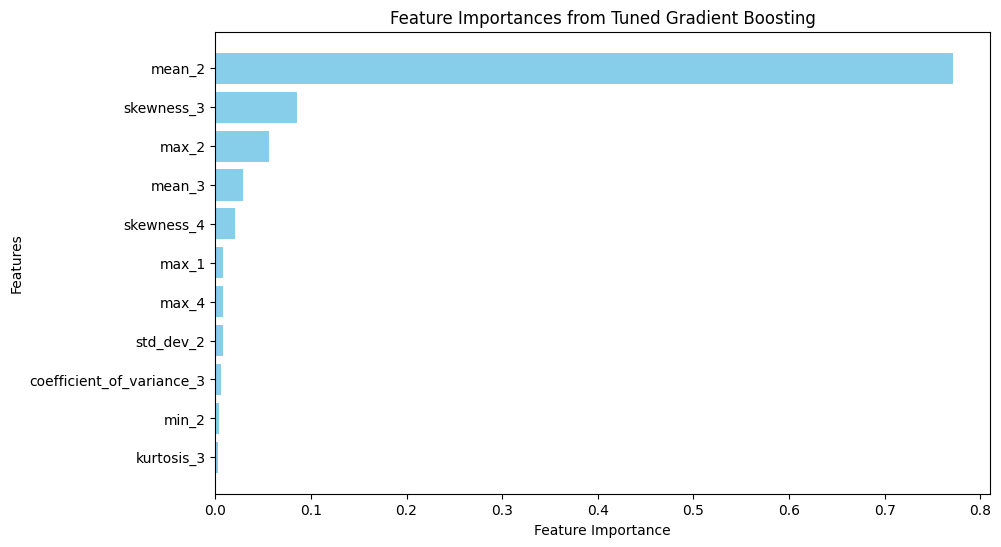

In [ ]:

# Step 4: Define the parameter grid for Gradient Boosting
param_grid_gb = {
    'n_estimators': [50, 100, 150,200, 300],
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'max_depth': [3, 4,5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'alpha': [0.005, 0.01, 0.05, 0.1, 0.5]
}


# Step 5: Initialize the GradientBoostingRegressor and apply GridSearchCV
gb_reg = GradientBoostingRegressor(random_state=0)
grid_search_gb = GridSearchCV(estimator=gb_reg, param_grid=param_grid_gb,
                              cv=10, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the model
grid_search_gb.fit(X_train_reduced, y_train)

# Get the best model
best_gb = grid_search_gb.best_estimator_

# Step 6: Evaluate the tuned model

print("RMSE Score for Gradient Boosting With Hyperparameter Tuning")

# Training set evaluation
y_pred_train_gb = best_gb.predict(X_train_reduced)
mse_train_gb = mean_squared_error(y_train, y_pred_train_gb)
rmse_train_gb = np.sqrt(mse_train_gb)
print('Training RMSE:', rmse_train_gb)

# Validation set evaluation
y_pred_val_gb = best_gb.predict(X_val_reduced)
mse_val_gb = mean_squared_error(y_val, y_pred_val_gb)
rmse_val_gb = np.sqrt(mse_val_gb)
print('Validation RMSE:', rmse_val_gb)

# Test set evaluation
y_pred_test_gb = best_gb.predict(X_test_reduced)
mse_test_gb = mean_squared_error(y_test, y_pred_test_gb)
rmse_test_gb = np.sqrt(mse_test_gb)
print('Test RMSE:', rmse_test_gb)

# Best hyperparameters found
print("Best Hyperparameters for Gradient Boosting:", grid_search_gb.best_params_)

# Step 7: (Optional) Plot the feature importances from the tuned model
sorted_importances = pd.DataFrame({
    'Feature': important_features,
    'Importance': best_gb.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(sorted_importances['Feature'], sorted_importances['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importances from Tuned Gradient Boosting')
plt.gca().invert_yaxis()
plt.show()